![](https://cdn-images-1.medium.com/max/880/1*rPrehw_Oa8KT8OnYIfnRkQ.png)

## Abstract:
Twitter is one of the platforms widely used by people to express their opinions and showcase sentiments on various occasions. Sentiment analysis is an approach to analyze data and retrieve sentiment that it embodies.
The tweet format is very small, which generates a whole new dimension of problems like the use of slang, abbreviations, etc. This article reports on the exploration and preprocessing of data, transforming data into a proper input format and classify the user's perspective via tweets into positive(non-racist) and negative (racist) by building supervised learning models using Python and NLTK library.

The objective of this project is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or non-sexist sentiment associated with it. So, the task is to classify racist or non-racist tweets from other tweets.
Given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist and label ‘0’ denotes the tweet is not racist, our objective is to predict the labels on the given test dataset.

We will be using F1 score as evaluation criteria for the below mentioned classification algorithms:
1. Logistic Regression
2. Naive Bayes
3. SVM Classfier
4. Random Forest Classifier
5. XGboost

Lastly, we will try to tune the hyper-parameters using Grid search for obtaining the best model from the above mentioned classification algorithms for better predictions.

We have created an Assesment based on NLP and Statistical Modelling

## Importing required libraries 

In [36]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

### Loading the data from the Input Data

In [37]:
train = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

### Workflow

![](https://cdn-images-1.medium.com/max/880/1*AjBD7nmt-udGSwS6YjwR5A.jpeg)

### Understanding summary statistics and target variable distribution

In [38]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [39]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [40]:
train.tail(1000)

,id,label,tweet
30962,30963,0,@user @user -- christian senator prays for president's death and this is what frank tweets about.
30963,30964,0,#boom another #car #company going #electricvehicle on the world! #futureofwork #entrepreneur i'm
30964,30965,0,@user @user @user you best stick to selling younique. you're not a writer but you are a theif.
30965,30966,0,@user @user my best friend sunday
30966,30967,0,share #laughter with your #dad for the #happiest #fathersday ever!
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððððððâ¤ï¸
31958,31959,0,to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher
31959,31960,0,listening to sad songs on a monday morning otw to work is sad
31960,31961,1,"@user #sikh #temple vandalised in in #calgary, #wso condemns act"


In [41]:
train[train['label'] == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [42]:
train[train['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


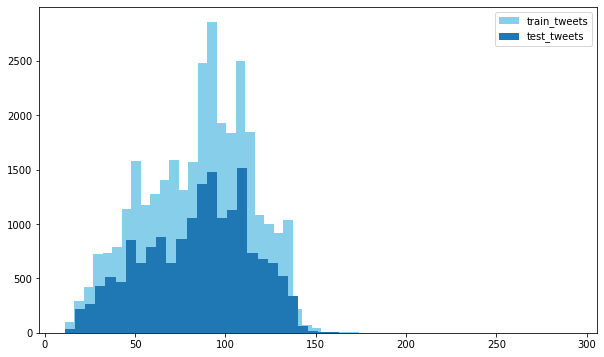

In [43]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()
plt.figure(figsize=(10,6))
plt.hist(length_train, bins=50, label="train_tweets",color = 'skyblue')
plt.hist(length_test, bins=50, label="test_tweets")
plt.legend()

### Pre-Processing

The main issue with text data is that it is all in text format (strings). However, Machine learning algorithms need some sort of numerical feature vector in order to perform the task. Basic text pre-processing includes:



#### Data Cleaning

In [44]:
merge = train.append(test, ignore_index=True, sort=False)
merge.shape

(49159, 3)

#### Removing unwanted text patterns from the tweets:

In [45]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

#### 1. Removing Twitter Handles (@user)

In [46]:
merge['tidy_tweet'] = np.vectorize(remove_pattern)(merge['tweet'], "@[\w]*") 
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


#### 2. Removing Punctuations, Numbers, and Special Characters

In [47]:
merge['tidy_tweet'] = merge['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


#### 3. Removing Short Words

In [48]:
merge['tidy_tweet'] = merge['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [49]:
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


### Tokenization

#### *It is just the term used to describe the process of converting the normal text strings into a list of tokens i.e. words that we actually want. Sentence tokenizer can be used to find the list of sentences, and Word tokenizer can be used to find the list of words in strings.*

#### 4. Text Normalization

In [50]:
tokenized_tweet = merge['tidy_tweet'].apply(lambda x: x.split()) 
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

#### 5. Stemming

Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form - generally a written word form. For example, if we were to stem the following words: "Stems", "Stemming", "Stemmed", "and Stemtization", the result would be a single word "stem".

In [51]:
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

### Transformation

Adding the tidy tweets back to our main (merge) data frame

In [52]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
merge['tidy_tweet'] = tokenized_tweet
merge.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


### Visualizing the tidy tweets


A) Understanding the common words used in the tweets: WordCloud

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A word cloud is an image made of words that together resemble a cloudy shape. The clouds give greater prominence to words that appear more frequently in the source text. You can tweak your clouds with different fonts, layouts, and color schemes.

Let’s visualize all the words our data using the wordcloud plot.

In [56]:
from wordcloud import WordCloud
def plot_wordCloud(words):
    wordcloud = WordCloud(width=800, height=500, background_color='grey', random_state=21, max_font_size=110).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

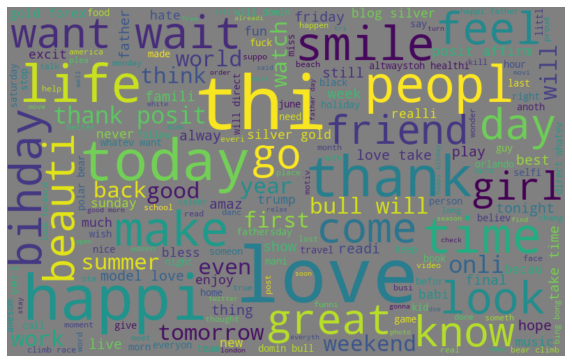

In [57]:
all_words = ' '.join([text for text in merge['tidy_tweet']])
plot_wordCloud(all_words)

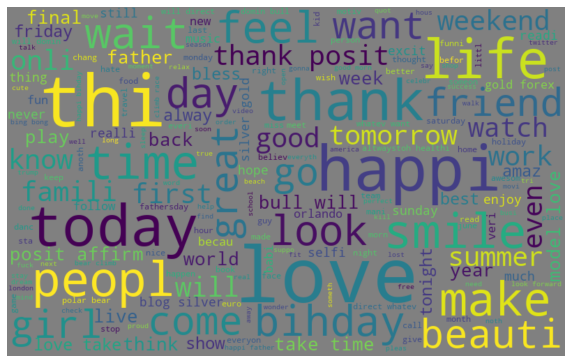

In [58]:
normal_words =' '.join([text for text in merge['tidy_tweet'][merge['label'] == 0]])
plot_wordCloud(normal_words)

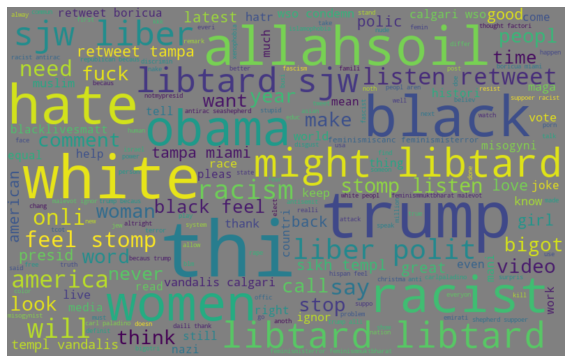

In [59]:
negative_words = ' '.join([text for text in merge['tidy_tweet'][merge['label'] == 1]])
plot_wordCloud(negative_words)

### Hashtag Analysis

In [60]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [61]:
# extracting hashtags from non racist tweets

HT_regular = hashtag_extract(merge['tidy_tweet'][merge['label'] == 0])

# extracting hashtags from racist tweets
HT_negative = hashtag_extract(merge['tidy_tweet'][merge['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

### Hashtag's in Non-racist tweets

[Text(0, 0.5, 'Number of Tweets')]

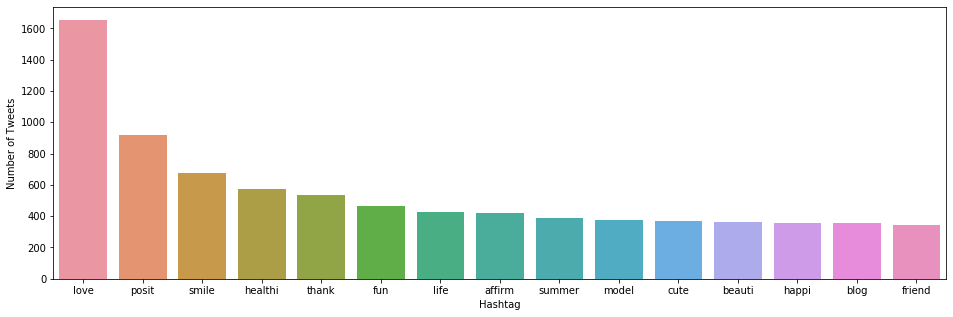

In [23]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 15 most frequent hashtags     
d = d.nlargest(columns="Count", n = 15) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Number of Tweets')

### Hashtag's in Racist Tweets

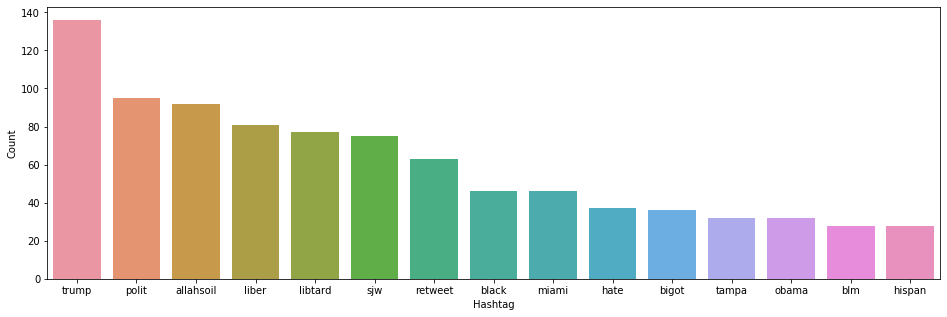

In [24]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 15 most frequent hashtags
e = e.nlargest(columns="Count", n = 15)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")

#### We observe that the positive hastags are mostly sentiments of gratitude, *love and happiness*. However the negative hashtags are associated with specific *human personalities*

### Extracting Features from Cleaned Tweets

### Bag-of-words

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity

In [64]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(merge['tidy_tweet'])


### TF-IDF Features

TF-IDF stands for Term Frequency–Inverse Document Frequency: In a large text corpus, some words have high frequency but very little meaningful information. If we use the count data directly to train a model, the very frequent tokens with little meaning will have a significant influence over the low frequency but far more interesting terms. So it is necessary to normalize and re-weight the word count result. We do so in the following:

In [65]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(merge['tidy_tweet'])

### Word2Vec Embeddings

Word2vec is a two-layer neural net that processes text. Its input is a text corpus and its output is a set of vectors

In [66]:
tokenized_tweet = merge['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(merge['tidy_tweet']), epochs=20)

(6510028, 7536020)

In [67]:
model_w2v.wv.most_similar(positive="thanku")

[('unborn', 0.8084810972213745),
 ('bane', 0.7786133289337158),
 ('minni', 0.7753437161445618),
 ('sperm', 0.7746363878250122),
 ('ilovey', 0.7705514430999756),
 ('#viamiano', 0.7704233527183533),
 ('deadbeat', 0.767947256565094),
 ('#aldubebfathersday', 0.7627497315406799),
 ('#tvk', 0.7598947882652283),
 ('ant', 0.7587903738021851)]

In [69]:
model_w2v.wv.most_similar(positive="hate")

[('muzzi', 0.5455754995346069),
 ('heterosexu', 0.512225329875946),
 ('bigotri', 0.505609929561615),
 ('#bullshit', 0.5042892694473267),
 ('sought', 0.5022450685501099),
 ('conniv', 0.501751184463501),
 ('wat', 0.5010256767272949),
 ('persecut', 0.49712634086608887),
 ('vindict', 0.49082040786743164),
 ('inflict', 0.48920395970344543)]

In [70]:
len(model_w2v['donald'])

200

### Preparing Vectors for Tweets

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [71]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

#### Preparing word2vec feature set...

In [33]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(49159, 200)

In [34]:
tqdm.pandas(desc="progress-bar")

#### To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [35]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [36]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets


#### Now let's train a doc2vec model.

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.

In [37]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

100%|███████████████████████████████████████████████████████████████████████| 49159/49159 [00:00<00:00, 1207541.96it/s]


In [38]:
model_d2v.train(labeled_tweets, total_examples= len(merge['tidy_tweet']), epochs=15)

#### Preparing doc2vec Feature Set

In [39]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(merge)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 200)

# Model Building¶
We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

1. Logistic Regression
2. Naive Bayes
3. SVM Classfier
4. Random Forest Classifier
5. XGboost

#### Defining Methods to be used for our evaluation criteria

In [40]:
MODEL_ID = []
Accuracy = []
LOG_CV_ERR = []
F1Score = []
def calculate_log_cv_error(logmodel,X_train,y_train):
    ms_errors= cross_val_score(logmodel, X_train, y_train, cv=5, scoring = make_scorer(mean_squared_error))
    rms_errors = np.sqrt(ms_errors)
    mean_rms_error = rms_errors.mean()
    return mean_rms_error

In [41]:
def evaluate_model(logmodel,X_train,X_test,y_train,y_test,predictions):
    log_cv_error = calculate_log_cv_error(logmodel,X_train,y_train)
    print(f'\nClassification Report:\n{classification_report(y_test,predictions)}')
    print('')
    print(f'\nConfusion Matrix:\n{confusion_matrix(y_test,predictions)}')
    print('')
    print (f'\nAccuracy Score:  {accuracy_score(y_test,predictions)}')
    print("Cross Validation Error: ",log_cv_error)
    logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
    LOG_CV_ERR.append(log_cv_error)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

###  Evalucation Criteria
![](https://acutecaretesting.org/-/media/acutecaretesting/articles/table-iv-categorization-of-roc-curves.gif?w=235&h=139&as=1&la=en)
**Confusion matrix**

It is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values. gives us a matrix as output and describes the complete performance of the model. 

**Accuracy**: Overall, how often is the classifier correct?    
(TP+TN)/total 

**Area Under Curve**

Area Under Curve(AUC) is one of the most widely used metrics for evaluation. It is used for binary classification problem. AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example.
 
False Positive Rate and True Positive Rate both have values in the range [0, 1].. AUC is the area under the curve of plot False Positive Rate vs True Positive Rate at different points in [0, 1]. 

Area under ROC curve is often used as a measure of quality of the classification models. A random classifier has an area under the curve of 0.5, while AUC for a perfect classifier is equal to 1. In practice, most of the classification models have an AUC between 0.5 and 1 

As evident, AUC has a range of [0, 1]. The greater the value, the better is the performance of our model. 

When a classifier cannot distinguish between the two groups, the area will be equal to 0.5 (the ROC curve will coincide with the diagonal). When there is a perfect separation of the two groups, i.e., no overlapping of the distributions, the area under the ROC curve reaches to 1 (the ROC curve will reach the upper left corner)

**F1 Score**

F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is [0, 1]. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).
High precision but lower recall, gives you an extremely accurate, but it then misses a large number of instances that are difficult to classify. The greater the F1 Score, the better is the performance of our model. Mathematically, it can be expressed as :
 
F1 Score tries to find the balance between precision and recall.
•	Precision : It is the number of correct positive results divided by the number of positive results predicted by the classifier.
 
Precision
•	Recall : It is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).
 


### 1. Logistic Regression

Logistic Regression is a classification algorithm could help us predict whether the given Tweet is Racist or not. Logistic regression predictions are distinct. We can also view probability scores underlying the model's classifications. Logistic regression transforms its output using the logistic sigmoid function to return a probability value which can then be mapped to two or more discrete classes. There are 3 types of Logistic Regression. Binary, Multi, and Ordinal. Here is the metric evaluation of the Logistic Regression.

#### Bag-of-Words Features

In [42]:
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [43]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')


F1_Score: 0.5307820299500832


#### TF-IDF Features

In [44]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [45]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5446507515473032


#### Word2Vec Features

In [46]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [47]:
lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.6214022140221402



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8905
           1       0.63      0.62      0.62       684

    accuracy                           0.95      9589
   macro avg       0.80      0.79      0.80      9589
weighted avg       0.95      0.95      0.95      9589



Confusion Matrix:
[[8655  250]
 [ 263  421]]


Accuracy Score:  0.9465011992908541
Cross Validation Error:  0.21977888221953515


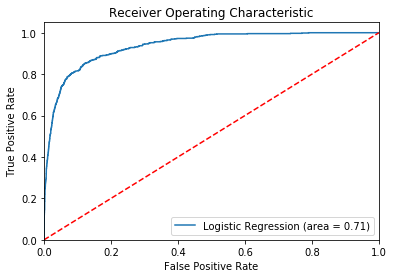

In [48]:
evaluate_model(lreg,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction_int)
MODEL_ID.append('Logistic Regression')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int))

#### Doc2Vec Features

In [49]:
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:]

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

In [50]:
lreg.fit(xtrain_d2v, ytrain)

prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.3802938634399308


## 2. Naive Bayes

Naive Baye is a classification technique based on the Bayes' Theorem with an assumption of independence among predictors. Bayes' Theorem provides a way in which an equation is describing the relationship of conditional probabilities of statistical quantities. In Bayesian classification, we're interested in finding the probability of a label given some observed features. There are three types of Naive Bayes model. Gaussian, Multinomial, and Bernoulli. Gaussian is basically used for classification problems whereas Multinomial is used to get the distinct counts. Bernoulli is used if the feature vectors are binary. Bernoulli is effective in text classification with a bag of words models where the 1 & 0 are "words occur in the document" and "words do not occur in the document".

#### Bag-of-Words Features

In [51]:
model = BernoulliNB()

model.fit(xtrain_bow, ytrain) # training the model

prediction = model.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5078534031413612


#### TF-IDF Features

In [52]:
model.fit(xtrain_tfidf, ytrain)

prediction = model.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5078534031413612


#### Word2Vec Features

In [53]:
model.fit(xtrain_w2v, ytrain)

prediction = model.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.4453781512605042



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8905
           1       0.31      0.77      0.45       684

    accuracy                           0.86      9589
   macro avg       0.65      0.82      0.68      9589
weighted avg       0.93      0.86      0.89      9589



Confusion Matrix:
[[7739 1166]
 [ 154  530]]


Accuracy Score:  0.862342267181145
Cross Validation Error:  0.3434595113611804


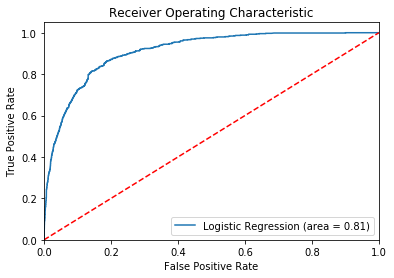

In [54]:
evaluate_model(model,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction_int)
MODEL_ID.append('Naive Bayes')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int))

#### Doc2Vec Features

In [55]:
model.fit(xtrain_d2v, ytrain)

prediction = model.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.3074018126888217


### 3. Support Vector Machine

SVM is a supervised machine learning algorithm which is used for classification and regression problem. In SVM we perform the classification by finding the hyperplane that differentiates between two classes very well. The Kernel trick technique is used to transform data and then based on the data it finds an optimal boundary between the possible outputs. SVM can be optimized using hyperparameters such as Kernels, Regularization, Gamma, and Margin. SVM works really well with a clear margin of separation and high dimensional spaces

#### Bag-of-Words Features

In [56]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5092592592592592


#### TF-IDF Features

In [57]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5104831358249772


#### Word2Vec Features

In [58]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.6105100463678517



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8905
           1       0.65      0.58      0.61       684

    accuracy                           0.95      9589
   macro avg       0.81      0.78      0.79      9589
weighted avg       0.94      0.95      0.95      9589



Confusion Matrix:
[[8690  215]
 [ 289  395]]


Accuracy Score:  0.9474397747418918
Cross Validation Error:  0.21896941407746917


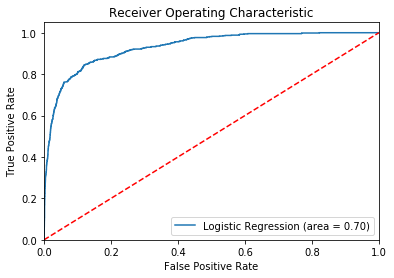

In [59]:
evaluate_model(svc,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction_int)
MODEL_ID.append('Support Vector Classifier')
Accuracy.append(accuracy_score(yvalid, prediction_int))
F1Score.append(f1_score(yvalid, prediction_int))

#### Doc2Vec Features

In [60]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
F1_Score = f1_score(yvalid, prediction_int) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.24944812362030905


### 4. RandomForest
![](https://image.slidesharecdn.com/randomforest-140705101902-phpapp01/95/random-forest-4-638.jpg?cb=1404555579)
Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

#### Bag-of-Words Features

In [61]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5529225908372828


#### TF-IDF Features

In [62]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.562152133580705


#### Word2Vec Features

In [63]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5026968716289105



Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8905
           1       0.96      0.34      0.50       684

    accuracy                           0.95      9589
   macro avg       0.96      0.67      0.74      9589
weighted avg       0.95      0.95      0.94      9589



Confusion Matrix:
[[8895   10]
 [ 451  233]]


Accuracy Score:  0.9519240796746272
Cross Validation Error:  0.2192543003691349


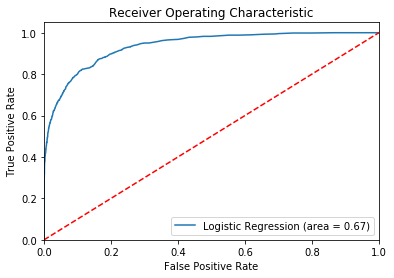

In [64]:
evaluate_model(rf,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction)
MODEL_ID.append('Random Forest CLassifier')
Accuracy.append(accuracy_score(yvalid, prediction))
F1Score.append(f1_score(yvalid, prediction))

#### Doc2Vec Features

In [65]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.06497175141242938


### 5. XGBoost
![](https://image.slidesharecdn.com/0782ee51-165d-4e34-a09c-2b7f8dacff01-150403064822-conversion-gate01/95/feature-importance-analysis-with-xgboost-in-tax-audit-21-638.jpg?cb=1450092771)

Thee are 4 Boosting Machine Learning Algorithms 
1. Gradient Boosting Machine (GBM)
2. Extreme Gradient Boosting Machine (XGBM)
3. LightGBM
4. CatBoost

Boosting is one such technique that uses the concept of ensemble learning. A boosting algorithm combines multiple simple models to generate the final output. The working procedure of XGBoost is that it combines the predictions from multiple decision trees. All the weak learners in a gradient boosting machine are decision trees. The trees in XGBoost are built sequentially, trying to correct the errors of the previous trees.

#### Bag-of-Words Features

In [66]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5247706422018349


#### TF-IDF Features

In [67]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain)
prediction = xgb.predict(xvalid_tfidf)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.5394265232974911


#### Word2Vec Features

In [68]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain)
prediction = xgb.predict(xvalid_w2v)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')


F1_Score: 0.6625550660792953



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8905
           1       0.83      0.55      0.66       684

    accuracy                           0.96      9589
   macro avg       0.90      0.77      0.82      9589
weighted avg       0.96      0.96      0.96      9589



Confusion Matrix:
[[8830   75]
 [ 308  376]]


Accuracy Score:  0.9600584002502868
Cross Validation Error:  0.19729690784743398


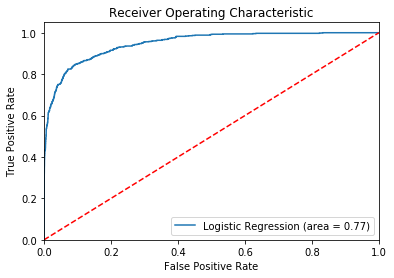

In [69]:
evaluate_model(xgb,xtrain_w2v,xvalid_w2v,ytrain,yvalid,prediction)
MODEL_ID.append('XGBOOST')
Accuracy.append(accuracy_score(yvalid, prediction))
F1Score.append(f1_score(yvalid, prediction))

#### Doc2Vec Features

In [70]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain)
prediction = xgb.predict(xvalid_d2v)
F1_Score = f1_score(yvalid, prediction) # calculating f1 score
print(f'F1_Score: {F1_Score}')

F1_Score: 0.3684210526315789


# Hyper-Parameters Tuning for Xgboost

Here we will use DMatrices. A DMatrix can contain both the features and the target.

In [71]:
import xgboost as xgb
dtrain = xgb.DMatrix(xtrain_w2v, label=ytrain)
dvalid = xgb.DMatrix(xvalid_w2v, label=yvalid)
dtest = xgb.DMatrix(test_w2v)

In [72]:
# Parameters that we are going to tune
params = {
    'objective':'binary:logistic',
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1
}


We will prepare a custom evaluation metric to calculate F1 score.

In [73]:
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds >= 0.3).astype(np.int)
    return [('f1_score', f1_score(labels, preds))]

### General Approach for Parameter Tuning

We will follow the steps below to tune the parameters.

1. Choose a relatively high learning rate. Usually a learning rate of 0.3 is used at this stage.
2. Tune tree-specific parameters such as max_depth, min_child_weight, subsample, colsample_bytree keeping the learning rate fixed.
3. Tune the learning rate.
4. Finally tune gamma to avoid overfitting.

### Tuning max_depth and min_child_weight

In [74]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,10) 
    for min_child_weight in range(5,8)
]

In [75]:
%%capture
max_f1 = 0. # initializing with 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Cross-validation
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

#### Updating max_depth and min_child_weight parameters and suppressing the grid search verbose using %%capture

In [76]:
params['max_depth'] = 7
params['min_child_weight'] = 5

### Tuning subsample and colsample.

In [77]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)]
]

In [78]:
%%capture
max_f1 = 0.
best_params = None
for subsample, colsample in gridsearch_params:
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # Update our parameters
    params['colsample'] = colsample
    params['subsample'] = subsample

    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = (subsample, colsample)

print("Best params: {}, {}, F1 Score: {}".format(best_params[0], best_params[1], max_f1))

#### Updating subsample and colsample_bytree and suppressing the grid search verbose using %%capture

In [79]:
params['subsample'] = .8
params['colsample_bytree'] = .5

### Tuning  learning rate.

In [80]:
%%capture
max_f1 = 0.
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # Update ETA
    params['eta'] = eta

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=1000,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=20
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = eta

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

#### Updating learning rate and suppressing the grid search verbose using %%capture

In [81]:
params['eta'] = .1

### Tuning  gamma value.

In [82]:
%%capture
max_f1 = 0.
best_params = None
for gamma in range(0,15):
    print("CV with gamma={}".format(gamma/10.))

    # Update ETA
    params['gamma'] = gamma/10.

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        feval= custom_eval,
        num_boost_round=200,
        maximize=True,
        seed=16,
        nfold=5,
        early_stopping_rounds=10
    )

    # Finding best F1 Score
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print("\tF1 Score {} for {} rounds".format(mean_f1, boost_rounds))
    if mean_f1 > max_f1:
        max_f1 = mean_f1
        best_params = gamma/10.

print("Best params: {}, F1 Score: {}".format(best_params, max_f1))

#### Updating gamma value and suppressing the grid search verbose using %%capture

In [83]:
params['gamma'] = .6

In [84]:
params

{'objective': 'binary:logistic',
 'max_depth': 7,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.5,
 'colsample': 0.9,
 'gamma': 0.6}

In [85]:
%%capture
xgb_model = xgb.train(
    params,
    dtrain,
    feval= custom_eval,
    num_boost_round= 1000,
    maximize=True,
    evals=[(dvalid, "Validation")],
    early_stopping_rounds=10
)

In [86]:
test_pred = xgb_model.predict(dtest)
test['label'] = (test_pred >= 0.3).astype(np.int)


In [87]:
leaderboard = pd.DataFrame({'Model_ID':MODEL_ID, 'F1Score':F1Score,'Accuracy':Accuracy})
leaderboard

,Model_ID,F1Score,Accuracy
0,Logistic Regression,0.621402,0.946501
1,Naive Bayes,0.445378,0.862342
2,Support Vector Classifier,0.610510,0.947440
3,Random Forest CLassifier,0.502697,0.951924
4,XGBOOST,0.662555,0.960058


From the above consolidated analysis, we are able to comprehend that the XGBoost model works pretty well with our data improving the f1 score and accuracy relative to the other machine learning algorithms applied to our model.


### Assesments Based on NLP and Statistical Learning

Getting Hands Dirty With NLP and Statistical Modeling- Advances in Data Sciences and Architecture - INFO 7390 https://www.proprofs.com/quiz-school/story.php?title=mjcynzi3nwanez

### Published Blog on Medium

https://medium.com/@kumar.anand/twitter-sentiment-analysis-b9a12dbb2043

## Conclusion
In this project, we used multiple training models to make prediction and tried to find the most appropriate model on our dataset.During the process, we learned the analyzing steps and training models in NLTK and scikit-learn library which are helpful and easy to use.
With different vectorizer, TFIDF and Count vectorizer, it will generate different result. For example, we can improve the model by removing words in very low or high frequency by TFIDF. It will make the prediction model to filter outliers and improve the accuracy of model.

On evaluation of the models like Logistic Regression, SVM, Random Forest and XGBoost on various features extracted which are Bag of words, Word2Vec, Doc2Vec and TF_IDF. Considering the evaluation metric of F1 score, our best performing model is XGBoost with tuned params applied on the Word2Vec features with an F1 score of 0.66.

### Contribution

Referred - 30%
Self     - 70%

##  Citations
https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython 
-- To hide the warning messages

https://github.com/mwaskom/seaborn/pull/1380 -- To resolve Matplotlib version issue.

https://stackoverflow.com/questions/10326015/singular-matrix-issue-with-numpy -- To resolve singular matrix issues


https://www.datacamp.com/courses/natural-language-processing-fundamentals-in-python --NLP Fundamentals

https://medium.com/analytics-vidhya/building-a-simple-chatbot-in-python-using-nltk-7c8c8215ac6e -- TF-IDF logic

https://public.tableau.com/views/BNPParibasCardifClaimsManagement-ExploratoryAnalysis/Sheet1?%3Aembed=y&%3AshowVizHome=no&%3Adisplay_count=y&%3Adisplay_static_image=y -- Understanding Data

### Licensing

Copyright 2020 Anand Kumar & Sohail Budhwani

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.